# F1tenth

In [2]:
import gym
import numpy as np



## Environment playground

In [5]:
# racecar_env = gym.make(
#     'f110_gym:f110-v0',
#     map='./f1tenth_gym/gym/f110_gym/envs/maps/vegas',
#     map_ext='.png'
# )

racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png'
)

In [4]:
obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 0.], # pose of ego
             [2., 0., 0.]])  # pose of 2nd agent
) 

obs

{'ego_idx': 0,
 'scans': [array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365]),
  array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365])],
 'poses_x': [0.0, 2.0],
 'poses_y': [0.0, 0.0],
 'poses_theta': [0.0, 0.0],
 'linear_vels_x': [0.0, 0.0],
 'linear_vels_y': [0.0, 0.0],
 'ang_vels_z': [0.0, 0.0],
 'collisions': array([0., 0.]),
 'lap_times': array([0.01, 0.01]),
 'lap_counts': array([0., 0.])}

In [5]:
state = np.concatenate([
    obs['scans'][0],
    np.array(obs['linear_vels_x'][:1]),
    np.array(obs['linear_vels_y'][:1]),
])
state.shape

(1082,)

In [6]:
speeds = np.random.rand(2, 1)*2
pi_4 = 3.1415/8
pi_2 = 3.1415/4
angles = np.random.rand(2, 1)*pi_2-pi_4
actions = np.concatenate([angles, speeds], axis=1)

actions

array([[-0.0596855 ,  0.44670051],
       [-0.05675966,  1.8354974 ]])

In [2]:
## action consists of ndarray(num_agent, 2) 0: steering angle 1: velocity
## the reward function is only for the first agent

import time
import gym 
import numpy as np


racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png',
    num_agents=1
)
steps = 0

obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 1.5]]) 
) 

rewards = []

while not done:
    
    speeds = np.random.rand(2, 1)*20
    pi_4 = 3.1415/8
    pi_2 = 3.1415/4
    speeds[1][0] = 0.1
    angles = np.random.rand(2, 1)*pi_2-pi_4
    actions = np.concatenate([angles, speeds], axis=1)

    obs, step_reward, done, info = racecar_env.step(actions)
    rewards.append(step_reward)
    
    racecar_env.render()
    steps += 1
    
    if steps > 500:
        break

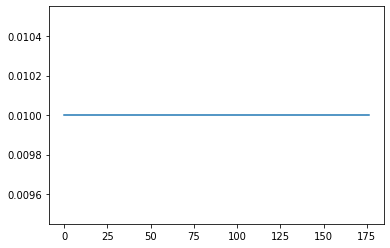

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)

## Define environment wrapper

### waypoints

In [ ]:
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

from numba import njit

from pyglet.gl import GL_POINTS


# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t

# @njit(fastmath=False, cache=True)
def get_actuation(pose_theta, lookahead_point, position, lookahead_distance, wheelbase):
    """
    Returns actuation
    """
    waypoint_y = np.dot(np.array([np.sin(-pose_theta), np.cos(-pose_theta)]), lookahead_point[0:2]-position)
    speed = lookahead_point[2]
    if np.abs(waypoint_y) < 1e-6:
        return speed, 0.
    radius = 1/(2.0*waypoint_y/lookahead_distance**2)
    steering_angle = np.arctan(wheelbase/radius)
    return speed, steering_angle

class PurePursuitPlanner:
    """
    Example Planner
    """
    def __init__(self, conf, wb):
        self.wheelbase = wb
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        self.drawn_waypoints = []

    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

    def render_waypoints(self, e):
        """
        update waypoints being drawn by EnvRenderer
        """

        #points = self.waypoints

        points = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        
        scaled_points = 50.*points

        for i in range(points.shape[0]):
            if len(self.drawn_waypoints) < points.shape[0]:
                b = e.batch.add(1, GL_POINTS, None, ('v3f/stream', [scaled_points[i, 0], scaled_points[i, 1], 0.]),
                                ('c3B/stream', [183, 193, 222]))
                self.drawn_waypoints.append(b)
            else:
                self.drawn_waypoints[i].vertices = [scaled_points[i, 0], scaled_points[i, 1], 0.]
        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None

    def plan(self, pose_x, pose_y, pose_theta, lookahead_distance, vgain):
        """
        gives actuation given observation
        """
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, lookahead_distance, position, pose_theta)

        if lookahead_point is None:
            return 4.0, 0.0

        speed, steering_angle = get_actuation(pose_theta, lookahead_point, position, lookahead_distance, self.wheelbase)
        speed = vgain * speed

        return speed, steering_angle

def main():
    """
    main entry point
    """

    work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}
    
    with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
        conf_dict = yaml.load(file, Loader=yaml.FullLoader)
    conf = Namespace(**conf_dict)

    planner = PurePursuitPlanner(conf, 0.17145+0.15875)

    def render_callback(env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

        planner.render_waypoints(env_renderer)

    env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
    env.add_render_callback(render_callback)
    
    obs, step_reward, done, info = env.reset(np.array([[conf.sx, conf.sy, conf.stheta]]))
    env.render()

    laptime = 0.0
    start = time.time()

    while not done:
        speed, steer = planner.plan(obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0], work['tlad'], work['vgain'])
        obs, step_reward, done, info = env.step(np.array([[steer, speed]]))
        laptime += step_reward
        env.render(mode='human')
        
    print('Sim elapsed time:', laptime, 'Real elapsed time:', time.time()-start)

main()

### waypoint handler

In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace



# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t
    
    
CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)

        
        work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None
    
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):
        

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(action)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, 1.8, position, 0.9033)
        
        print(position, lookahead_point)
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        

        next_state = self.to_vector_state(obs)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()



### checkpoint handler

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs][1:]
        self.t = 0
        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.next_cp_idx = 0
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        buck = 3
        scanner = np.zeros(1080//buck,)
        for i in range(1080//buck):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        scanner /= 10
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'])/5,
            np.array(obs['ang_vels_z'])
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        angle = action[0]*(np.pi/4)
#         action[1] = action[1]*5
        speed = 5
        act = np.array([[angle, speed]])
#         action = np.repeat(action, repeats=2, axis=0)
#         action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
#         print(action, position)
        
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(self.t+1, position, action[0], angle)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

## Env simple wrapper

In [9]:

CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)
        
        self.env = gym.make(
            'f110_gym:f110-v0',
            map='./f1tenth_gym/examples/example_map',
            map_ext='.png'
        )
        
        self.reset()
        self.prev_capture_coord = None
        
    def reset(self):
        obs, step_reward, done, info = self.env.reset(
            poses=np.array([[0., 0., 0.], 
                     [-1., -1., 0.]]) 
        )
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        obs, step_reward, done, info = self.env.step(action)
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        
        moving_forward_rew = 0

        if self.time_to_capture == 0:
            current_coord = [obs['poses_x'][0], obs['poses_y'][0]]
            dist = abs(current_coord[0] - self.prev_capture_coord[0]) + abs(current_coord[1] - self.prev_capture_coord[1])
            # print(f"prev coord:{self.prev_capture_coord}, current_coord:{current_coord}, dist:{dist}")
            
            self.prev_capture_coord = current_coord
            if dist < 2:
                # print("Neg reward")
                moving_forward_rew = -10

            self.time_to_capture = CAPTURE_TIME + 1

        next_state = self.to_vector_state(obs)
        # ang_vel = obs['ang_vels_z'][0]
        # print(obs['ang_vels_z'][0]*0.1)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()


## Render

In [ ]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = np.array([1.0, 0.0])
    obs, reward, done, _ = env.step(action)
    env.render()

# RAY algorithms

## ppo continuous actions

### continious env

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10, map_no=4):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.deterministic = deterministic
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = max_v
        self.map_no = map_no
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:4]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
#         self.low_theta = 1.1
#         self.high_theta = 2.1
#         print(f"initializing theta between: {self.low_theta} and {self.high_theta}")
        
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_no = np.random.randint(1, 5) if self.map_no is None else self.map_no
        map_path = f"./f1tenth_gym/examples/{map_no}"
        
        if self.deterministic:
            print(f"using map:{map_path}")
            
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext=self.conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        
        #theta = np.random.rand() * (self.high_theta - self.low_theta) + self.low_theta
        
        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        current_pos = self.checkpoints[random_idx][:2]
        theta = self.checkpoints[random_idx][2] + np.pi/2
        obs, step_reward, done, info = self.env.reset(np.array([[current_pos[0], current_pos[1], theta]]))
        #obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, theta]]))
 
        self.next_cp_idx = random_idx + 1
        #self.next_cp_idx = 1
    
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):
        angle = action[0]*np.pi/4.
        speed = action[1]*5.0 + 5.0
        act = np.array([[angle, speed]])
        
#         if not self.deterministic:
#             act[0] += np.random.normal(0, 0.05, size=(2,))
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        reward = 0
#         if obs['lap_counts'][0] == 1.0:
#             done = True
#             reward = 1.0
        
        position = np.array([pose_x, pose_y])
        
        if obs['collisions'][0] == 1.0:
            done = True
            reward = -1
            
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        
        #padding from wall:
        scans = obs['scans'][0]
        if min(scans) < 0.1:
            reward -= 0.1
            
        self.t += 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

number of waypoints:79


### training

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 10
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300, 300]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['train_batch_size'] = 5000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
print(trainer.config)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0 or (i<50 and i%10==0):
        with open('./checkpoints/ppo_cont_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/ppo_cont")
        print("checkpoint saved at", cp)


2022-03-08 17:45:09,459	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-08 17:45:09,460	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=39527) number of waypoints:79
(RolloutWorker pid=39527) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39508) number of waypoints:79
(RolloutWorker pid=39508) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39504) number of waypoints:79
(RolloutWorker pid=39504) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39528) number of waypoints:79
(RolloutWorker pid=39528) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39521) number of waypoints:79
(RolloutWorker pid=39521) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39520) number of waypoints:79
(RolloutWorker pid=39520) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39517) number of waypoints:79
(RolloutWorker pid=39517) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39494) number of waypoints:79
(RolloutWorker pid=39494) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39490) number of waypoints:79
(RolloutWorker pid=39490) initi

(RolloutWorker pid=39527) 2022-03-08 17:45:23,337	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=39528) 2022-03-08 17:45:23,679	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=39487) 2022-03-08 17:45:23,629	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=39508) 2022-03-08 17:45:23,749	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

{'num_workers': 10, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 10000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [512, 512], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_pre

2022-03-08 17:46:06,028	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:1.6736842105263159
checkpoint saved at ./checkpoints/ppo_cont/checkpoint_000001/checkpoint-1
episode: 1 reward:1.97
episode: 2 reward:1.98
episode: 3 reward:2.25
episode: 4 reward:3.02
episode: 5 reward:3.6
episode: 6 reward:5.19
episode: 7 reward:3.64
episode: 8 reward:4.02
episode: 9 reward:6.18
episode: 10 reward:7.08
checkpoint saved at ./checkpoints/ppo_cont/checkpoint_000011/checkpoint-11
episode: 11 reward:8.21
episode: 12 reward:8.45
episode: 13 reward:10.19
episode: 14 reward:9.47
episode: 15 reward:9.17
episode: 16 reward:10.27
episode: 17 reward:11.219000000000001
episode: 18 reward:11.509
episode: 19 reward:12.109000000000002
episode: 20 reward:13.01
checkpoint saved at ./checkpoints/ppo_cont/checkpoint_000021/checkpoint-21
episode: 21 reward:13.21
episode: 22 reward:12.94


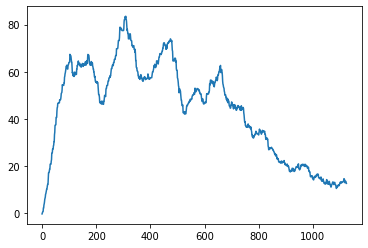

In [4]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [7]:
trainer.save("./ppo_cp_2")

'./ppo_cp_2/checkpoint_000043/checkpoint-43'

In [18]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300, 300]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['train_batch_size'] = 5000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_cont/checkpoint_000751/checkpoint-751')

number of waypoints:79


2022-03-14 12:33:40,729	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-03-14 12:33:40,742	INFO trainable.py:472 -- Restored on 128.205.39.153 from checkpoint: ./checkpoints/ppo_cont/checkpoint_000751/checkpoint-751
2022-03-14 12:33:40,743	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 751, '_timesteps_total': 3755000, '_time_total': 12026.480172395706, '_episodes_total': 2561}


In [3]:
obs = env.reset()

NameError: name 'env' is not defined

In [14]:
trainer.compute_single_action(observation=obs, explore=False)

array([0.9726   , 0.9282523], dtype=float32)

In [17]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_single_action(observation=obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    


number of waypoints:79


## discrete action

### define environment

In [100]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config, deterministic=False):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(364,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = 5.0
        self.deterministic = deterministic
        
        self.action_map = {
            0: [0., 0.],
            1: [0., self.max_v],
            2: [-np.pi/4, self.max_v],
            3: [np.pi/4, self.max_v],
            4: [-np.pi/6, self.max_v],
            5: [np.pi/6, self.max_v],
            6: [-np.pi/4, self.max_v/2], #later
            7: [np.pi/4, self.max_v/2] #later
        }
        self.action_space = gym.spaces.Discrete(len(self.action_map),)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        self.t = 0
        
        print(f"x and y range: {self.min_x}to{self.max_x} and {self.min_y}to{self.max_y}")
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800

        print(f"using map:{conf.map_path}")
        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None

        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        
        self.next_cp_idx = 1
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
            np.array(obs['poses_x'][:1]/(self.max_x-self.min_x)),
            np.array(obs['poses_y'][:1]/(self.max_y-self.min_y))
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        act = np.array([self.action_map[action]])
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(action)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({}).render()

x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard
(scheduler +6m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +6m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


### training

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 30
DEFAULT_CONFIG['num_gpus'] = 2
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 1
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e8)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]
APEX_DEFAULT_CONFIG['final_epsilon'] = 0.1
APEX_DEFAULT_CONFIG['buffer_size'] =  2000000

# trainer = dqn.ApexTrainer(env=F110Env, config=APEX_DEFAULT_CONFIG)
trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0:
        with open('./checkpoints/ppo_disc_r2', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/ppo_disc_hard_cp2")
        print("checkpoint saved at", cp)


In [7]:
APEX_DEFAULT_CONFIG

{'num_workers': 32,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 50,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 512,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,


(RolloutWorker pid=1477) 2022-02-19 17:34:53,395	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1486) 2022-02-19 17:34:53,556	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1506) 2022-02-19 17:34:53,728	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1480) 2022-02-19 17:34:53,666	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBa

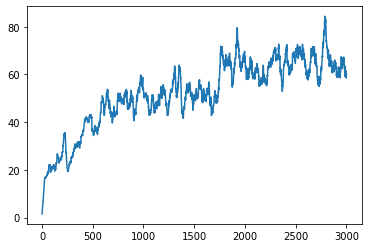

In [1]:
import pickle
import matplotlib.pyplot as plt

with open('checkpoints/ppo_disc_r2', 'rb') as f:
    l = pickle.load(f)
    
plt.plot(l)

In [3]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 0
APEX_DEFAULT_CONFIG['num_workers'] = 0
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e8)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]
APEX_DEFAULT_CONFIG['final_epsilon'] = 0.1


trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_disc_hard_cp2/checkpoint_002701/checkpoint-2701')

2022-02-24 14:56:20,179	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-24 14:56:20,180	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


2022-02-24 14:56:20,566	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-02-24 14:56:20,568	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-02-24 14:56:20,618	INFO trainable.py:472 -- Restored on 128.205.39.153 from checkpoint: ./checkpoints/ppo_disc_hard_cp2/checkpoint_002701/checkpoint-2701
2022-02-24 14:56:20,618	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 2701, '_timesteps_total': 21553980, '_time_total': 58813.86238908768, '_episodes_total': 9190}


In [5]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


FileNotFoundError: [Errno 2] No such file or directory: './f1tenth_gym/examples/hard.png'

In [7]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action, _, info = trainer.get_policy().compute_single_action(obs)
    best_action = info['action_dist_inputs'].argmax()
    obs, reward, done, _ = env.step(best_action)
    env.render()
    


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


E0224 14:46:47.268370986   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.304396184   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.368199447   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.400014867   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.421832661   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.446290439   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.623234275   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.658036917   13634 fork_pos

(scheduler +4m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


## discrete with generalization over maps

### environment

In [7]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10.0, map_no=4):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.deterministic = deterministic
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = max_v
        self.map_no = map_no
        
        self.action_map = {
            0: [0., 0.],
            1: [0.0, self.max_v],
            2: [np.pi/4, self.max_v],
            3: [-np.pi/4, self.max_v],           
        }
        self.action_space = gym.spaces.Discrete(len(self.action_map),)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:4]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
        self.low_theta = 1.1
        self.high_theta = 2.1
        print(f"initializing theta between: {self.low_theta} and {self.high_theta}")
        
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_no = np.random.randint(1, 5) if self.map_no is None else self.map_no
        map_path = f"./f1tenth_gym/examples/{map_no}"
        
        if self.deterministic:
            print(f"using map:{map_path}")
            
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext=self.conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        
        #theta = np.random.rand() * (self.high_theta - self.low_theta) + self.low_theta
        
        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        current_pos = self.checkpoints[random_idx][:2]
        theta = self.checkpoints[random_idx][2] + np.pi/2
        obs, step_reward, done, info = self.env.reset(np.array([[current_pos[0], current_pos[1], theta]]))
        #obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, theta]]))
 
        self.next_cp_idx = random_idx + 1
        #self.next_cp_idx = 1
    
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        act = np.array([self.action_map[action]])
        
#         if not self.deterministic:
#             act[0][0] += np.random.normal(0, 0.05)
#             act[0][1] += np.random.normal(0, 2.0)
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]

        reward = 0
        
#         if obs['lap_counts'][0] == 1.0:
#             reward = 1.0
#             done = True
        
        position = np.array([pose_x, pose_y])
        
        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            
        scans = obs['scans'][0]
        if min(scans) < 0.1:
            reward -= 0.1    
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

number of waypoints:79
initializing theta between: 1.1 and 2.1


### PPO 

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 10
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [200, 200]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['train_batch_size'] = 5000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
print("FINE TUNING")
trainer.restore('./checkpoints/safe_ppo/checkpoint_000101/checkpoint-101')

print(trainer.config)
rewards = []

import pickle

for i in range(1000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0 or (i<50 and i%10==0):
        with open('./checkpoints/safe_ppo_ft_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/safe_ppo_ft")
        print("checkpoint saved at", cp)


2022-03-11 13:32:06,153	WARNING ppo.py:223 -- `train_batch_size` (5000) cannot be achieved with your other settings (num_workers=10 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 500.


(RolloutWorker pid=506) number of waypoints:79
(RolloutWorker pid=506) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=531) number of waypoints:79
(RolloutWorker pid=531) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=516) number of waypoints:79
(RolloutWorker pid=516) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=519) number of waypoints:79
(RolloutWorker pid=519) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=525) number of waypoints:79
(RolloutWorker pid=525) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=535) number of waypoints:79
(RolloutWorker pid=535) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=533) number of waypoints:79
(RolloutWorker pid=533) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=529) number of waypoints:79
(RolloutWorker pid=529) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=530) number of waypoints:79
(RolloutWorker pid=530) initializing theta between: 1.1 and 2.1
(

(RolloutWorker pid=533) 2022-03-11 13:32:20,007	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=519) 2022-03-11 13:32:20,139	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=506) 2022-03-11 13:32:20,428	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=525) 2022-03-11 13:32:20,528	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEn

FINE TUNING
{'num_workers': 10, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 500, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 5000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [200, 200], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attentio

episode: 0 reward:10.166666666666666
checkpoint saved at ./checkpoints/safe_ppo_ft/checkpoint_000102/checkpoint-102
episode: 1 reward:15.785714285714286
episode: 2 reward:18.333333333333332
episode: 3 reward:21.161290322580644
episode: 4 reward:22.105263157894736
episode: 5 reward:22.52173913043478
episode: 6 reward:23.346153846153847
episode: 7 reward:23.625
episode: 8 reward:24.9672131147541
episode: 9 reward:26.159420289855074
episode: 10 reward:25.613333333333333
checkpoint saved at ./checkpoints/safe_ppo_ft/checkpoint_000112/checkpoint-112
episode: 11 reward:26.759493670886076
episode: 12 reward:26.41176470588235
episode: 13 reward:27.747252747252748
episode: 14 reward:27.96842105263158
episode: 15 reward:28.53
episode: 16 reward:29.87
episode: 17 reward:30.46
episode: 18 reward:31.49
episode: 19 reward:31.81
episode: 20 reward:31.8
checkpoint saved at ./checkpoints/safe_ppo_ft/checkpoint_000122/checkpoint-122
episode: 21 reward:32.39
episode: 22 reward:33.15
episode: 23 reward:33

In [4]:
# entropy can help I guess!
# try attention too
# padding punishment

#trainer.save('./checkpoints/ppo_gen3')

'./checkpoints/ppo_gen3/checkpoint_000040/checkpoint-40'

### rendering

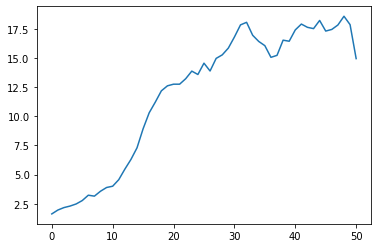

In [3]:
import matplotlib.pyplot as plt
import pickle
with open('checkpoints/ppo_gen1_r', 'rb') as f:
    rewards = pickle.load(f)
plt.plot(rewards)

In [1]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [200, 200]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/safe_ppo_ft/checkpoint_000302/checkpoint-302')
# trainer.evaluate()

ModuleNotFoundError: No module named 'ray'

In [4]:


done = False
env = F110Env({'explore':False}, deterministic=True, map_no=4, max_v=7)
obs = env.reset()

while not done:
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/4
using map:./f1tenth_gym/examples/4


### deterministic action

In [7]:
done = False
env = F110Env({'explore':False}, deterministic=True, map_no=4, max_v=10)
obs = env.reset()

while not done:
    action, _, info = trainer.get_policy().compute_single_action(obs)
    best_action = info['action_dist_inputs'].argmax()
    obs, reward, done, _ = env.step(best_action)
    env.render()
    


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/4
using map:./f1tenth_gym/examples/4


### APEX

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG

ray.shutdown()
ray.init()


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 1
APEX_DEFAULT_CONFIG['num_workers'] = 32
APEX_DEFAULT_CONFIG['rollout_fragment_length'] = 100
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e7)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [512, 512]
# APEX_DEFAULT_CONFIG['num_gpus_per_worker'] = 1/15
# APEX_DEFAULT_CONFIG['final_epsilon'] = 0.05
APEX_DEFAULT_CONFIG['target_network_update_freq'] = 10000
APEX_DEFAULT_CONFIG['train_batch_size'] = 256
APEX_DEFAULT_CONFIG['batch_mode'] = 'complete_episodes'

trainer = dqn.ApexTrainer(env=F110Env, config=APEX_DEFAULT_CONFIG)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0 or (i<50 and i%10==0):
        with open('./checkpoints/apex_gen2_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/apex_gen2")
        print("checkpoint saved at", cp)


2022-02-25 14:39:06,824	INFO simple_q.py:153 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-02-25 14:39:06,825	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=13839) number of waypoints:79
(RolloutWorker pid=13839) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13853) number of waypoints:79
(RolloutWorker pid=13853) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13827) number of waypoints:79
(RolloutWorker pid=13827) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13824) number of waypoints:79
(RolloutWorker pid=13824) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13856) number of waypoints:79
(RolloutWorker pid=13856) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13834) number of waypoints:79
(RolloutWorker pid=13834) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13844) number of waypoints:79
(RolloutWorker pid=13844) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13847) number of waypoints:79
(RolloutWorker pid=13847) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13832) number of waypoints:79
(RolloutWorker pid=13832) initi

(RolloutWorker pid=13839) 2022-02-25 14:39:19,608	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=13824) 2022-02-25 14:39:19,959	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=13827) 2022-02-25 14:39:21,249	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=13853) 2022-02-25 14:39:21,551	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

2022-02-25 14:39:32,467	INFO trainable.py:125 -- Trainable.setup took 25.645 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-02-25 14:39:32,470	WARNING util.py:55 -- Install gputil for GPU system monitoring.
(MultiAgentReplayBuffer pid=13842) 2022-02-25 14:39:34,250	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4705 GB (500000.0 batches of size 1, 2941 bytes each), available system memory is 540.16866304 GB
(MultiAgentReplayBuffer pid=13848) 2022-02-25 14:39:34,353	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4705 GB (500000.0 batches of size 1, 2941 bytes each), available system memory is 540.16866304 GB
(MultiAgentReplayBuffer pid=13849) 2022-02-25 14:39:34,807	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4705 GB (500000.0 batches of size 1, 2941 bytes each), available system memory is 540.16866304 GB
(MultiAge

In [4]:
APEX_DEFAULT_CONFIG

{'num_workers': 32,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 50,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 512,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  'fcnet_hiddens': [512, 512],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,


### rendering

In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [512, 512]




trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_gen1/checkpoint_000101/checkpoint-101')

number of waypoints:79
initializing theta between: 1.1 and 2.1


2022-02-24 17:31:41,328	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.
E0224 17:31:42.566541816   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:42.587183151   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:42.603914247   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-02-24 17:31:43,939	INFO trainable.py:472 -- Restored on 128.205.39.153 from checkpoint: ./checkpoints/ppo_gen1/checkpoint_000101/checkpoint-101
2022-02-24 17:31:43,940	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 101, '_timesteps_total': 404000, '_time_total': 1193.51722645759

In [4]:


done = False
env = F110Env({'explore':False}, deterministic=True)
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/3


2022-02-24 17:28:09,432	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


using map:./f1tenth_gym/examples/2


E0224 17:28:09.464016808   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.486268041   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.552270206   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.586315409   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.611037816   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.636488141   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.956462774   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.986253508   23296 fork_pos

### deterministic action

In [3]:
done = False
env = F110Env({'explore':False}, deterministic=True)
obs = env.reset()

while not done:
    action, _, info = trainer.get_policy().compute_single_action(obs)
    best_action = info['action_dist_inputs'].argmax()
    obs, reward, done, _ = env.step(best_action)
    env.render()
    


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/4
using map:./f1tenth_gym/examples/3


E0224 17:31:44.364789236   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.387505847   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.458213310   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.492264741   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.517877649   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.541289314   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.732439977   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.764952154   23712 fork_pos

## Racing environment

### follow the gap agent

In [2]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



###  classic control env

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class VFHEnv(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10, map_no=4, begin_pos=None):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.deterministic = deterministic
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = max_v
        self.map_no = map_no
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.begin_pos = begin_pos

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:4]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
#         self.low_theta = 1.1
#         self.high_theta = 2.1
#         print(f"initializing theta between: {self.low_theta} and {self.high_theta}")
        
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_no = np.random.randint(1, 5) if self.map_no is None else self.map_no
        map_path = f"./f1tenth_gym/examples/{map_no}"
        
        if self.deterministic:
            print(f"using map:{map_path}")
            
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext=self.conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        
        #theta = np.random.rand() * (self.high_theta - self.low_theta) + self.low_theta
        
        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        current_pos = self.checkpoints[random_idx][:2]
        theta = self.checkpoints[random_idx][2] + np.pi/2
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
        #obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, theta]]))
 
        self.next_cp_idx = random_idx + 1
        #self.next_cp_idx = 1
    
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
                
        state = [
            scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):
        act = np.array([action])
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        reward = 0
        
        position = np.array([pose_x, pose_y])
        
        if obs['collisions'][0] == 1.0:
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            done = True
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        
        #padding from wall:
        scans = obs['scans'][0]
        if min(scans) < 0.1:
            reward -= 0.1
            
        self.t += 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

VFHEnv({})

number of waypoints:79


### follow the gap and vfh

In [2]:
from f1tenth.pkg.src.pkg.vfh_gym import VFH

done = False
env = VFHEnv({}, map_no='SILVERSTONE_TRAIN', max_v=0, begin_pos=[0, 0, np.pi+1])
obs = env.reset()
vfh = VFH()
positions = []
ths = []
while not done:
    positions.append(obs[3])
#     velocity = Vector('v')
#     velocity.set(obs[1], 0)
#     pos = Vector('p')
#     pos.set(0, 0)
    v, th = vfh.process_observation(obs[0], {'linear_vel_x': obs[1], 'angular_vel_z': obs[2]})
#     print(obs[1], v, th)
#     ths.append(th)
    obs, r, done, _ = env.step([th, v])
    env.render()

number of waypoints:79


In [5]:
print(max(ths), min(ths))

0.4476903384201821 -0.3530283983221573


In [7]:
np.pi/6

0.5235987755982988

In [3]:
with open('./ss-wp.np', 'wb') as f:
    np.save(f, np.array(positions))


In [4]:
with open('./ss-wp.np', 'rb') as f:
    x = np.load(f)
    
print(x.shape)


(7759, 3)


### render classic control

In [59]:
done = False
speed = 5.0
env = F110Env({}, map_no=4, max_v=speed)
obs = env.reset()

agent = FGAgent(speed=speed)

while not done:
    obs = obs*10.0
    action = agent.get_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
#     break
    
env.close()


NameError: name 'F110Env' is not defined

### Race environment single car

- v1.3 added noise to lidar + padding
- v1.4 trying to tune r_cp/r_crash to achieve best perf with highest speed no noise 


In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace
from f1tenth.pkg.src.pkg.vfh_gym import VFH


class F110RaceEnv(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=12.0, map_name='SILVERSTONE_TRAIN', scan_range=10.0, n_step=1):
        self.deterministic = deterministic
        self.n_step = n_step
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(110,), dtype=np.float32)
        self.max_v = max_v
        self.map_name = map_name
        self.min_cp_dist = 2.0
        self.cp_reward = 0.05
        self.scan_range = scan_range
        
#         self.speed_map = {
#             0: self.max_v,
#             1: self.max_v*3./4,
#             2: self.max_v*1./2,
#             3: self.max_v*1./4, 
#             4: 0.0
#         }
#         self.action_space = gym.spaces.Discrete(len(self.speed_map),)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        
        self.vfh = None
        self.reset()
        
  
    def reset(self):
        self.vfh = VFH()
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        no = "2" if np.random.rand() < 0.5 else ""
        map_path = f"./f1tenth_gym/examples/{self.map_name}{no}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        with open('./ss-wp.np', 'rb') as f:
            wps = np.load(f)
            
        idxs = [i%20 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs]
#         print(f"number of checkpoints: {len(self.checkpoints)}")

        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        start_point = self.checkpoints[random_idx]
    
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.next_cp_idx = random_idx + 1
        self.vfh_state = None
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        self.vfh_state = [scanner, obs['linear_vels_x'][0]]
        
        buck = 10
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/3.0,
        ])
        
#         noise = np.random.normal(loc=0.0, scale=0.03, size=state.shape)
#         state = state + noise
        
        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
        
    def _step(self, action):
        reward = 0
#         vfh_v = Vector('v')
#         vfh_v.set(self.vfh_state[1], 0)
#         pos = Vector('p')
#         pos.set(0, 0)
#         v, th = self.vfh.process_lidar(self.vfh_state[0], vfh_v, pos)

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
#         act_v += np.random.normal(loc=0.0, scale=2.0)
        
        th = action[1]*np.pi/6
#         act_v = self.speed_map[action]
        act = np.array([[th, act_v]])
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]


        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            
#         if np.min(obs['scans'][0]) < 0.1:
#             reward += -0.05

        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1
        
        return next_state, reward, done, info
    
    def step(self, action):
        done = False
        reward = 0
        self.t += 1
            
        if self.n_step > 1:
            while not done and self.t % self.n_step != 0:
                next_state, reward, done, info = self._step(action)
            return next_state, reward, done, info
        else:
            return self._step(action)
    
    
    def render(self):
        self.env.render()

F110RaceEnv({})

#### train single car

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


#### ppo

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()

# with half cheeta configs

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 16
DEFAULT_CONFIG['num_gpus'] = 1.0
# DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [512, 512]
DEFAULT_CONFIG['kl_coeff'] = 1.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['num_envs_per_worker'] = 16
DEFAULT_CONFIG['train_batch_size'] = 100000
DEFAULT_CONFIG['sgd_minibatch_size'] = 4096
#DEFAULT_CONFIG['sgd_minibatch_size'] = 256
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
DEFAULT_CONFIG['lr'] = .0003

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
# print("FINE TUNING")
# trainer.restore('./checkpoints/race_vfh/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []
best_reward = -100

import pickle

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        with open('./checkpoints/race_v1.4_max12_ratio20_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/race_v1.4_max12_ratio20")
        print("checkpoint saved at", cp)


2022-04-06 01:46:38,981	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=16 num_envs_per_worker=16 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 390.
2022-04-06 01:46:38,981	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-06 01:46:38,982	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=51474) 2022-04-06 01:46:47,058	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=51495) 2022-04-06 01:46:47,052	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVecto

{'num_workers': 16, 'num_envs_per_worker': 16, 'create_env_on_driver': False, 'rollout_fragment_length': 390, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

2022-04-06 01:47:55,466	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.7368047982551799
checkpoint saved at ./checkpoints/race_v1.4_max12_ratio20/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.7084415584415585


In [12]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [100, 100]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/race_v1.4_max12/checkpoint_000071/checkpoint-71')
# trainer.evaluate()



2022-04-05 23:56:54,425	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=0 num_envs_per_worker=16 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6250.
2022-04-05 23:56:54,970	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-04-05 23:57:02,771	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-04-05 23:57:02,780	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ./checkpoints/race_v1.4_max12/checkpoint_000071/checkpoint-71
2022-04-05 23:57:02,781	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 71, '_timesteps_total': 14177280, '_time_total': 2416.0965507030487, '_episodes_total': 10327}



#### render

In [14]:


done = False
env = F110RaceEnv({}, n_step=1)
obs = env.reset()

while not done:
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
#     env.render()
    
env.close()

crashed!


#### exporting model 

In [6]:
import torch 

torch.save(trainer.get_policy().model._logits._model.state_dict(), 'models/logit_sd', _use_new_zipfile_serialization=False)
torch.save(trainer.get_policy().model._hidden_layers[0]._model.state_dict(), 'models/h1_sd', _use_new_zipfile_serialization=False)
torch.save(trainer.get_policy().model._hidden_layers[1]._model.state_dict(), 'models/h2_sd', _use_new_zipfile_serialization=False)

In [ ]:
import torch
import torch.functional as F



class Policy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden1 = torch.nn.Sequential(
            torch.nn.Linear(in_features=110, out_features=256, bias=True),
            torch.nn.Tanh()
        )
        self.hidden2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=256, bias=True),
            torch.nn.Tanh()
        )
        self.logits =  torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=4, bias=True),
        )
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        return self.logits(x)
    

policy = Policy()

# Load weights
# policy.hidden1.load_state_dict(torch.load('models/h1_sd'))
# policy.hidden2.load_state_dict(torch.load('models/h2_sd'))
# policy.logits.load_state_dict(torch.load('models/logit_sd'))

#perform action
#acts = torch.clip(policy(torch.tensor(obs, dtype=torch.float32)), min=-1, max=1).detach().cpu().numpy()
#v, th = acts[0], acts[1]

#### using exported model

In [3]:
from scripts.custom_policy import PolicyWrapper


done = False
env = F110RaceEnv({}, n_step=1)
obs = env.reset()

policy = PolicyWrapper()
r = 0
while not done:
#     acts = torch.clip(policy(torch.tensor(obs, dtype=torch.float32)), min=-1, max=1).detach().cpu().numpy()
    
#     print(acts)
#     v, th = acts[0], acts[1]
    v, th = policy.get_action(obs)
    print(v, th)
    obs, reward, done, _ = env.step([v, th])
#     env.render()
    r += reward
    print(r)
    
env.close()


1.0 0.37013546
0.2
1.0 0.34092352
0.2
1.0 0.3420911
0.2
1.0 0.4052923
0.2
1.0 0.38189122
0.2
1.0 0.28156552
0.2
1.0 0.28585944
0.2
1.0 0.37611958
0.2
1.0 0.16352184
0.2
1.0 0.29618657
0.2
1.0 0.19726114
0.2
1.0 0.15922867
0.2
1.0 0.16396195
0.2
1.0 0.29294977
0.2
1.0 0.1093522
0.2
1.0 0.2745308
0.4
1.0 0.097809784
0.4
1.0 0.17636843
0.4
1.0 0.011456521
0.4
1.0 0.07404199
0.4
1.0 0.15794502
0.4
1.0 0.119899064
0.4
1.0 0.1259089
0.4
1.0 0.112349
0.4
1.0 0.033998556
0.4
1.0 0.20420992
0.4
1.0 -0.08392943
0.4
1.0 0.05822929
0.4
1.0 -0.06374846
0.4
1.0 -0.213697
0.4
1.0 -0.081432715
0.4
1.0 -0.1437836
0.4
1.0 -0.11736743
0.4
1.0 -0.17556617
0.4
1.0 0.06883757
0.4
1.0 0.092115425
0.4
1.0 0.083510794
0.4
1.0 0.17288743
0.4
1.0 0.020921288
0.4
1.0 -0.012403237
0.4
1.0 -0.10942281
0.4
1.0 -0.060241744
0.4
1.0 0.016925296
0.4
1.0 -0.061540797
0.4
1.0 -0.10301319
0.4
1.0 -0.13773583
0.4
1.0 -0.14256978
0.4
1.0 0.13053337
0.4
1.0 0.082990065
0.6000000000000001
1.0 0.29454985
0.6000000000000001
1.0

1.0 0.1950244
4.400000000000001
1.0 0.0380968
4.400000000000001
1.0 -0.26728484
4.400000000000001
1.0 -0.4747384
4.400000000000001
1.0 -0.58729875
4.400000000000001
1.0 -0.5403278
4.400000000000001
1.0 -0.5528638
4.400000000000001
1.0 -0.6199674
4.400000000000001
1.0 -0.37837827
4.400000000000001
1.0 -0.23061904
4.400000000000001
1.0 -0.18029457
4.400000000000001
1.0 -0.073408835
4.600000000000001
1.0 0.14047228
4.600000000000001
1.0 0.25778124
4.600000000000001
1.0 0.26519385
4.600000000000001
1.0 0.25393215
4.600000000000001
1.0 0.31144607
4.600000000000001
1.0 0.27059817
4.600000000000001
1.0 0.17175885
4.600000000000001
1.0 0.04237844
4.600000000000001
1.0 0.051866308
4.600000000000001
1.0 -0.19281566
4.600000000000001
1.0 -0.4165521
4.800000000000002
1.0 -0.5729307
4.800000000000002
1.0 -0.3607059
4.800000000000002
1.0 -0.35750946
4.800000000000002
1.0 -0.414811
4.800000000000002
1.0 -0.34172884
4.800000000000002
1.0 -0.11553101
4.800000000000002
1.0 0.015298618
4.800000000000002


1.0 0.23296449
9.999999999999996
1.0 0.021712748
9.999999999999996
1.0 -0.14627647
9.999999999999996
1.0 0.16120666
9.999999999999996
1.0 0.3774173
9.999999999999996
1.0 0.058950603
9.999999999999996
1.0 -0.10156119
9.999999999999996
1.0 0.090607345
9.999999999999996
1.0 -0.20877096
9.999999999999996
1.0 -0.49688992
9.999999999999996
1.0 -0.5227805
10.199999999999996
1.0 -0.9420512
10.199999999999996
1.0 -0.5092606
10.199999999999996
1.0 -0.7736031
10.199999999999996
1.0 -0.6780844
10.199999999999996
1.0 -0.44184116
10.199999999999996
1.0 -0.122630835
10.199999999999996
1.0 0.3204602
10.199999999999996
1.0 0.5267434
10.199999999999996
1.0 0.41602093
10.199999999999996
1.0 0.47624665
10.399999999999995
1.0 0.62943435
10.399999999999995
1.0 1.0
10.399999999999995
1.0 1.0
10.399999999999995
1.0 0.9629883
10.399999999999995
1.0 0.88048506
10.399999999999995
1.0 0.98715854
10.399999999999995
1.0 0.7794564
10.399999999999995
1.0 0.71566707
10.399999999999995
1.0 0.7197588
10.399999999999995


1.0 -0.0117853
14.999999999999979
1.0 0.0014775377
14.999999999999979
1.0 -0.18434381
14.999999999999979
1.0 -0.37202466
14.999999999999979
1.0 -0.80653644
14.999999999999979
1.0 -0.70549667
14.999999999999979
1.0 -0.85583854
14.999999999999979
1.0 -0.79770654
15.199999999999978
1.0 -0.69305056
15.199999999999978
1.0 -0.66014254
15.199999999999978
1.0 -0.6807105
15.199999999999978
1.0 -0.3409951
15.199999999999978
1.0 -0.41149464
15.199999999999978
1.0 -0.09035668
15.199999999999978
1.0 -0.018745394
15.199999999999978
1.0 0.06615648
15.199999999999978
1.0 0.13461503
15.199999999999978
1.0 0.24078694
15.199999999999978
1.0 0.30050072
15.399999999999977
1.0 0.423933
15.399999999999977
1.0 0.6196753
15.399999999999977
1.0 0.63744235
15.399999999999977
1.0 0.5361736
15.399999999999977
1.0 0.7004268
15.399999999999977
1.0 0.80059254
15.399999999999977
1.0 0.79159725
15.399999999999977
1.0 0.79355115
15.399999999999977
1.0 0.12687093
15.399999999999977
0.94840455 -0.10590167
15.3999999999999

20.39999999999996
1.0 0.533543
20.39999999999996
1.0 0.6243299
20.39999999999996
1.0 0.8609535
20.39999999999996
1.0 0.9182439
20.59999999999996
1.0 0.80582
20.59999999999996
1.0 1.0
20.59999999999996
1.0 0.84956175
20.59999999999996
1.0 1.0
20.59999999999996
1.0 0.70782596
20.59999999999996
1.0 0.63839585
20.59999999999996
1.0 0.67417127
20.59999999999996
1.0 0.46966138
20.59999999999996
1.0 0.3316863
20.59999999999996
1.0 0.53939545
20.799999999999958
1.0 0.27700904
20.799999999999958
1.0 0.03243299
20.799999999999958
1.0 -0.22974886
20.799999999999958
1.0 -0.18620114
20.799999999999958
1.0 -0.29189298
20.799999999999958
1.0 -0.55307585
20.799999999999958
1.0 -0.77223986
20.799999999999958
1.0 -0.7206064
20.799999999999958
1.0 -0.584857
20.799999999999958
1.0 -0.3285085
20.999999999999957
1.0 -0.012163999
20.999999999999957
1.0 0.037727684
20.999999999999957
1.0 0.50473136
20.999999999999957
1.0 0.5846057
20.999999999999957
1.0 0.526829
20.999999999999957
1.0 0.9540385
20.99999999999

25.99999999999994
1.0 0.31824636
25.99999999999994
1.0 0.51394
26.19999999999994
1.0 0.53095174
26.19999999999994
1.0 0.64111364
26.19999999999994
1.0 0.68181044
26.19999999999994
1.0 0.5240235
26.19999999999994
1.0 0.3922695
26.19999999999994
1.0 0.35774186
26.19999999999994
1.0 0.39255312
26.19999999999994
1.0 0.44183344
26.19999999999994
1.0 0.52781504
26.19999999999994
1.0 0.36560848
26.19999999999994
1.0 0.40841636
26.399999999999938
1.0 0.07805659
26.399999999999938
1.0 -0.040509924
26.399999999999938
1.0 -0.29012963
26.399999999999938
1.0 -0.5496051
26.399999999999938
1.0 -0.86805487
26.399999999999938
1.0 -0.8967851
26.399999999999938
1.0 -0.9223174
26.399999999999938
1.0 -1.0
26.399999999999938
1.0 -1.0
26.399999999999938
1.0 -0.82894826
26.399999999999938
1.0 -0.73809123
26.599999999999937
1.0 -0.4169291
26.599999999999937
1.0 -0.38543057
26.599999999999937
1.0 -0.2517611
26.599999999999937
1.0 0.06239237
26.599999999999937
1.0 0.117530584
26.599999999999937
1.0 0.29472396
26

31.19999999999992
1.0 -0.89145654
31.19999999999992
1.0 -0.62667054
31.19999999999992
1.0 -0.43029281
31.19999999999992
1.0 -0.07327929
31.19999999999992
1.0 -0.042717367
31.19999999999992
1.0 0.017906813
31.19999999999992
1.0 0.010717122
31.19999999999992
1.0 0.060045928
31.19999999999992
1.0 0.06281802
31.19999999999992
1.0 0.11749706
31.39999999999992
1.0 0.1369563
31.39999999999992
1.0 0.16559526
31.39999999999992
1.0 -0.01527104
31.39999999999992
1.0 -0.0320172
31.39999999999992
1.0 -0.3282665
31.39999999999992
1.0 -0.42189157
31.39999999999992
1.0 -0.6658434
31.39999999999992
1.0 -0.71638894
31.39999999999992
1.0 -0.8133564
31.39999999999992
1.0 -0.86393166
31.59999999999992
1.0 -0.74932766
31.59999999999992
1.0 -0.72892123
31.59999999999992
1.0 -0.8378098
31.59999999999992
0.9336326 -0.87035406
31.59999999999992
1.0 -0.89557636
31.59999999999992
1.0 -0.8019199
31.59999999999992
1.0 -0.6229053
31.59999999999992
0.78794086 -0.26520956
31.79999999999992
0.81298184 -0.1373646
31.799

1.0 -0.96562123
36.999999999999986
1.0 -0.6872077
36.999999999999986
1.0 -0.30209813
36.999999999999986
1.0 -0.32309762
36.999999999999986
1.0 -0.26041043
36.999999999999986
1.0 -0.25625566
36.999999999999986
1.0 -0.055595472
36.999999999999986
1.0 0.06768365
36.999999999999986
1.0 0.4361799
36.999999999999986
1.0 0.529633
36.999999999999986
1.0 0.5891601
36.999999999999986
1.0 0.5317054
36.999999999999986
1.0 0.62836695
37.19999999999999
1.0 0.6884181
37.19999999999999
1.0 0.666913
37.19999999999999
1.0 0.75866264
37.19999999999999
1.0 0.6861632
37.19999999999999
1.0 0.55931985
37.19999999999999
1.0 0.49505743
37.19999999999999
1.0 0.26620865
37.19999999999999
1.0 0.14333092
37.19999999999999
1.0 -0.32139537
37.19999999999999
1.0 -0.6458435
37.19999999999999
1.0 -0.784444
37.19999999999999
1.0 -0.86434746
37.19999999999999
1.0 -0.83944666
37.19999999999999
1.0 -1.0
37.19999999999999
1.0 -0.99145174
37.19999999999999
1.0 -0.9270954
37.19999999999999
1.0 -0.8153767
37.39999999999999
1.0

40.60000000000004
1.0 0.5706114
40.80000000000004
1.0 0.76356626
40.80000000000004
1.0 0.794045
40.80000000000004
1.0 0.47281247
40.80000000000004
1.0 0.6030655
40.80000000000004
1.0 0.23115642
40.80000000000004
1.0 -0.27239138
40.80000000000004
1.0 -0.4918769
40.80000000000004
1.0 -0.71546924
40.80000000000004
1.0 -0.9402062
40.80000000000004
1.0 -1.0
41.00000000000004
1.0 -0.93477166
41.00000000000004
1.0 -0.80286866
41.00000000000004
1.0 -0.73911417
41.00000000000004
1.0 -0.7309463
41.00000000000004
1.0 -0.81303537
41.00000000000004
1.0 -0.754789
41.00000000000004
1.0 -0.62786716
41.00000000000004
1.0 -0.5410874
41.00000000000004
1.0 -0.4865582
41.00000000000004
1.0 -0.39847913
41.00000000000004
1.0 -0.25713754
41.200000000000045
1.0 -0.11910439
41.200000000000045
1.0 -0.15015194
41.200000000000045
1.0 0.038493633
41.200000000000045
1.0 0.2621037
41.200000000000045
1.0 0.17378621
41.200000000000045
1.0 0.2701119
41.200000000000045
1.0 0.27001515
41.200000000000045
1.0 0.32427382
41.

0.9841471 0.0148210805
45.80000000000011
1.0 -0.05627373
45.80000000000011
1.0 -0.026831837
45.80000000000011
0.9300939 0.07825288
46.000000000000114
1.0 -0.03494823
46.000000000000114
1.0 -0.17757574
46.000000000000114
1.0 -0.18184522
46.000000000000114
1.0 0.010681955
46.000000000000114
1.0 -0.052105814
46.000000000000114
1.0 -0.21440277
46.000000000000114
1.0 0.020277528
46.000000000000114
1.0 -0.09481406
46.000000000000114
1.0 -0.5128655
46.20000000000012
1.0 -0.4340154
46.20000000000012
1.0 -0.23034428
46.20000000000012
1.0 -0.39807078
46.20000000000012
1.0 -0.36135712
46.20000000000012
1.0 -0.50169563
46.20000000000012
1.0 -0.40248713
46.20000000000012
0.82899404 -0.32475355
46.20000000000012
0.96461284 0.09707132
46.20000000000012
1.0 -0.10935119
46.20000000000012
1.0 -0.08814469
46.20000000000012
1.0 -0.10698795
46.40000000000012
1.0 -0.09423441
46.40000000000012
1.0 0.02344769
46.40000000000012
1.0 -0.13299537
46.40000000000012
1.0 -0.20566003
46.40000000000012
0.938401 -0.037

1.0 0.16589288
51.20000000000019
1.0 0.28240147
51.20000000000019
1.0 0.10939552
51.20000000000019
1.0 0.1988352
51.20000000000019
1.0 0.12021989
51.20000000000019
0.765313 -0.31101212
51.20000000000019
0.7893696 -0.41016462
51.20000000000019
0.93079615 -0.4088327
51.20000000000019
1.0 -0.40985826
51.40000000000019
1.0 -0.65251434
51.40000000000019
1.0 -0.54691774
51.40000000000019
1.0 -0.533177
51.40000000000019
1.0 -0.5655514
51.40000000000019
1.0 -0.46143574
51.40000000000019
1.0 -0.6159188
51.40000000000019
1.0 -0.6833631
51.40000000000019
1.0 -0.6482461
51.40000000000019
1.0 -0.83980644
51.60000000000019
1.0 -0.525607
51.60000000000019
1.0 0.015181659
51.60000000000019
1.0 0.32128987
51.60000000000019
1.0 0.37140888
51.60000000000019
1.0 0.39129752
51.60000000000019
1.0 0.6202379
51.60000000000019
1.0 0.7220445
51.60000000000019
1.0 0.922852
51.60000000000019
1.0 0.9601426
51.60000000000019
1.0 0.9950651
51.60000000000019
1.0 0.9511023
51.800000000000196
1.0 1.0
51.800000000000196

56.20000000000026
1.0 -0.31471968
56.20000000000026
1.0 -0.2916132
56.20000000000026
1.0 -0.14568198
56.20000000000026
1.0 0.33169967
56.20000000000026
1.0 0.41481343
56.20000000000026
1.0 0.4976603
56.20000000000026
1.0 0.5195534
56.20000000000026
1.0 0.51287663
56.20000000000026
1.0 0.43986353
56.40000000000026
1.0 0.5105022
56.40000000000026
1.0 0.58823067
56.40000000000026
1.0 0.3349593
56.40000000000026
1.0 0.3300434
56.40000000000026
1.0 0.2388385
56.40000000000026
1.0 -0.062019408
56.40000000000026
1.0 -0.35862315
56.40000000000026
1.0 -0.5989568
56.40000000000026
1.0 -0.6920251
56.40000000000026
1.0 -0.6753062
56.40000000000026
1.0 -0.7381438
56.40000000000026
1.0 -0.9045155
56.40000000000026
1.0 -0.6917906
56.40000000000026
1.0 -0.6015723
56.40000000000026
1.0 -0.48962817
56.40000000000026
1.0 -0.46485505
56.40000000000026
1.0 -0.16899112
56.40000000000026
1.0 0.064879335
56.40000000000026
1.0 0.21772665
56.600000000000264
1.0 0.5571121
56.600000000000264
1.0 0.67556334
56.600

61.80000000000034
1.0 -1.0
61.80000000000034
1.0 -1.0
61.80000000000034
1.0 -1.0
61.80000000000034
1.0 -1.0
61.80000000000034
1.0 -1.0
61.80000000000034
1.0 -0.87806326
61.80000000000034
1.0 -0.6534622
61.80000000000034
1.0 -0.3519039
61.80000000000034
1.0 -0.5136803
61.80000000000034
1.0 -0.26127842
62.00000000000034
1.0 -0.20783137
62.00000000000034
1.0 -0.15828292
62.00000000000034
1.0 0.048778966
62.00000000000034
1.0 0.15975145
62.00000000000034
1.0 0.14901179
62.00000000000034
1.0 0.018155789
62.00000000000034
1.0 0.29492083
62.00000000000034
1.0 0.31202757
62.00000000000034
1.0 0.2331256
62.00000000000034
1.0 0.19165447
62.00000000000034
1.0 0.17246228
62.00000000000034
1.0 -0.14885344
62.00000000000034
1.0 -0.3409959
62.00000000000034
1.0 -0.23583366
62.00000000000034
1.0 -0.3414279
62.00000000000034
1.0 -0.3336579
62.200000000000344
1.0 -0.3092609
62.200000000000344
1.0 -0.33568442
62.200000000000344
1.0 -0.34671926
62.200000000000344
1.0 -0.3046563
62.200000000000344
1.0 -0.1

67.00000000000041
1.0 -0.40405205
67.00000000000041
1.0 -0.44127107
67.00000000000041
1.0 -0.17948835
67.00000000000041
1.0 -0.085996725
67.00000000000041
1.0 -0.00037174113
67.00000000000041
1.0 0.09399563
67.00000000000041
1.0 0.42028704
67.00000000000041
1.0 0.5962544
67.00000000000041
1.0 0.7102611
67.00000000000041
1.0 0.7916576
67.20000000000041
1.0 0.7038705
67.20000000000041
1.0 0.6475556
67.20000000000041
1.0 0.74438
67.20000000000041
1.0 0.6146847
67.20000000000041
1.0 0.7821841
67.20000000000041
1.0 0.5454839
67.20000000000041
1.0 0.59201014
67.20000000000041
1.0 0.513952
67.20000000000041
1.0 0.23305938
67.20000000000041
1.0 -0.18000504
67.20000000000041
1.0 -0.6857803
67.20000000000041
1.0 -0.865741
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -0.9180048
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -0.9698564
67.40000000000042
1.0 -1.0
67.40000000000042
1.0 -

72.8000000000005
1.0 -1.0
73.0000000000005
1.0 -1.0
73.0000000000005
1.0 -1.0
73.0000000000005
1.0 -1.0
73.0000000000005
1.0 -0.941522
73.0000000000005
1.0 -0.9969505
73.0000000000005
1.0 -0.9415781
73.0000000000005
1.0 -0.11871311
73.0000000000005
0.87847483 0.0392254
73.0000000000005
0.776996 0.08519703
73.0000000000005
0.7334379 0.38355586
73.2000000000005
0.9051069 0.5610043
73.2000000000005
1.0 0.5223674
73.2000000000005
1.0 0.36994848
73.2000000000005
1.0 0.4356725
73.2000000000005
1.0 0.5451446
73.2000000000005
1.0 0.31429678
73.2000000000005
1.0 0.18843105
73.2000000000005
1.0 0.1700015
73.2000000000005
1.0 0.32613033
73.2000000000005
1.0 0.56464076
73.4000000000005
1.0 0.59325457
73.4000000000005
1.0 0.72694486
73.4000000000005
1.0 0.80253386
73.4000000000005
1.0 0.9988103
73.4000000000005
1.0 0.68918306
73.4000000000005
1.0 0.42874435
73.4000000000005
1.0 0.14753395
73.4000000000005
1.0 -0.0428209
73.4000000000005
1.0 -0.70884615
73.4000000000005
1.0 -1.0
73.4000000000005
1.0

78.00000000000057
1.0 -0.12485941
78.00000000000057
1.0 0.19624922
78.00000000000057
1.0 0.4093918
78.00000000000057
1.0 0.5353044
78.00000000000057
1.0 0.5595274
78.00000000000057
1.0 0.52500314
78.00000000000057
1.0 0.78046626
78.00000000000057
1.0 0.7949165
78.00000000000057
1.0 1.0
78.20000000000057
1.0 0.8978455
78.20000000000057
1.0 0.89623886
78.20000000000057
1.0 0.73255265
78.20000000000057
1.0 0.5581598
78.20000000000057
1.0 0.37308037
78.20000000000057
1.0 -0.13083538
78.20000000000057
1.0 -0.48623937
78.20000000000057
1.0 -0.9131332
78.20000000000057
1.0 -1.0
78.20000000000057
1.0 -0.9595056
78.40000000000057
1.0 -0.99677885
78.40000000000057
1.0 -0.90572774
78.40000000000057
1.0 -0.9885141
78.40000000000057
1.0 -0.92420405
78.40000000000057
1.0 -0.83141834
78.40000000000057
1.0 -0.97959244
78.40000000000057
1.0 -0.84892607
78.40000000000057
1.0 -0.91183275
78.40000000000057
1.0 -0.9091966
78.40000000000057
1.0 -1.0
78.40000000000057
1.0 -0.97658783
78.60000000000058
1.0 -0

83.20000000000064
1.0 -0.48386666
83.20000000000064
1.0 -0.4626507
83.20000000000064
1.0 -0.23801512
83.20000000000064
1.0 -0.33336565
83.20000000000064
1.0 -0.34918794
83.20000000000064
1.0 -0.12502791
83.20000000000064
1.0 -0.07711486
83.20000000000064
1.0 0.09639296
83.20000000000064
1.0 0.31470135
83.20000000000064
1.0 0.500703
83.20000000000064
1.0 0.4540122
83.40000000000065
1.0 0.4467398
83.40000000000065
1.0 0.46917287
83.40000000000065
1.0 0.4332278
83.40000000000065
1.0 0.5971409
83.40000000000065
1.0 0.6273222
83.40000000000065
1.0 0.6357501
83.40000000000065
1.0 0.5471848
83.40000000000065
1.0 0.360147
83.40000000000065
1.0 0.025943173
83.40000000000065
1.0 -0.38510367
83.40000000000065
1.0 -0.5918437
83.40000000000065
1.0 -0.69912803
83.40000000000065
1.0 -0.78983164
83.40000000000065
1.0 -1.0
83.40000000000065
1.0 -1.0
83.40000000000065
1.0 -0.9525118
83.40000000000065
1.0 -0.8954833
83.40000000000065
1.0 -0.8721569
83.60000000000065
1.0 -0.5923164
83.60000000000065
1.0 -

1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -0.968058
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -1.0
88.80000000000072
1.0 -0.74908876
88.80000000000072
1.0 -0.55939645
88.80000000000072
1.0 -0.4772868
88.80000000000072
1.0 -0.3722994
88.80000000000072
1.0 -0.18906422
89.00000000000072
0.9432523 -0.007815482
89.00000000000072
0.8507941 0.250998
89.00000000000072
0.9085834 0.43239868
89.00000000000072
1.0 0.62611616
89.00000000000072
1.0 0.7299429
89.00000000000072
1.0 0.759021
89.00000000000072
1.0 0.83120537
89.00000000000072
1.0 0.87980527
89.00000000000072
1.0 0.8326797
89.00000000000072
1.0 0.6370266
89.00000000000072
1.0 0.3321016
89.00000000000072
1.0 0.2479518
89.00000000000072
1.0 0.31461322
89.00000000000072
1.0 0.10310228
89.00000000000072
1.0 -0.25787383
89.00000000000072
1.0 -0.5370241
89.00000

1.0 -0.59656084
94.0000000000008
1.0 -0.5797409
94.0000000000008
1.0 -0.6511285
94.0000000000008
1.0 -0.4626246
94.0000000000008
1.0 -0.3725315
94.0000000000008
1.0 0.3029497
94.0000000000008
1.0 0.23957226
94.0000000000008
1.0 0.16991061
94.0000000000008
1.0 0.117338136
94.0000000000008
1.0 0.109546706
94.0000000000008
1.0 -0.051531702
94.0000000000008
1.0 -0.06401056
94.0000000000008
1.0 -0.043467656
94.0000000000008
1.0 0.30195585
94.0000000000008
1.0 0.19083312
94.0000000000008
1.0 0.370813
94.2000000000008
1.0 0.5300441
94.2000000000008
1.0 0.40403688
94.2000000000008
1.0 0.0995857
94.2000000000008
1.0 -0.38219297
94.2000000000008
1.0 -0.6116599
94.2000000000008
1.0 -0.77928054
94.2000000000008
1.0 -1.0
94.2000000000008
1.0 -0.5138155
94.2000000000008
1.0 -0.45717815
94.2000000000008
1.0 -0.2678783
94.2000000000008
1.0 -0.5106418
94.2000000000008
1.0 -0.43339783
94.2000000000008
1.0 -0.17932138
94.2000000000008
1.0 -0.13981026
94.2000000000008
1.0 -0.26358172
94.2000000000008
1.0 

99.20000000000087
1.0 0.3762056
99.20000000000087
1.0 0.24501744
99.20000000000087
1.0 0.04246807
99.20000000000087
1.0 -0.21754369
99.20000000000087
1.0 -0.71114945
99.20000000000087
1.0 -0.81614673
99.20000000000087
1.0 -0.875633
99.20000000000087
1.0 -1.0
99.40000000000087
1.0 -0.99301565
99.40000000000087
1.0 -1.0
99.40000000000087
1.0 -1.0
99.40000000000087
1.0 -0.80032426
99.40000000000087
1.0 -0.78974795
99.40000000000087
1.0 -0.45443556
99.40000000000087
1.0 -0.35439035
99.40000000000087
1.0 -0.2891483
99.40000000000087
1.0 -0.064893976
99.40000000000087
1.0 0.08316606
99.40000000000087
1.0 0.3653683
99.40000000000087
1.0 0.40481585
99.40000000000087
1.0 0.49269572
99.40000000000087
1.0 0.577844
99.40000000000087
1.0 0.52438986
99.40000000000087
1.0 0.47504768
99.40000000000087
1.0 0.39022893
99.40000000000087
1.0 0.45938376
99.40000000000087
1.0 0.3388628
99.60000000000088
1.0 0.26607454
99.60000000000088
1.0 0.11927186
99.60000000000088
1.0 -0.4116151
99.60000000000088
1.0 -0

104.80000000000095
1.0 -0.20076656
104.80000000000095
1.0 -0.3619282
104.80000000000095
1.0 -0.30397898
105.00000000000095
1.0 -0.13046257
105.00000000000095
1.0 -0.04519938
105.00000000000095
1.0 0.11653328
105.00000000000095
1.0 0.2592115
105.00000000000095
1.0 0.49387857
105.00000000000095
1.0 0.6525629
105.00000000000095
1.0 0.6986893
105.00000000000095
1.0 0.6388194
105.00000000000095
1.0 0.65771526
105.00000000000095
1.0 0.64342767
105.00000000000095
1.0 0.67483056
105.00000000000095
1.0 0.6002995
105.00000000000095
1.0 0.49446157
105.00000000000095
1.0 0.085080296
105.00000000000095
1.0 -0.3429682
105.00000000000095
1.0 -0.54514366
105.20000000000095
1.0 -0.6171761
105.20000000000095
1.0 -0.7013267
105.20000000000095
1.0 -0.9024035
105.20000000000095
1.0 -0.97222567
105.20000000000095
1.0 -1.0
105.20000000000095
1.0 -1.0
105.20000000000095
1.0 -0.9698698
105.20000000000095
1.0 -1.0
105.20000000000095
1.0 -1.0
105.20000000000095
1.0 -1.0
105.20000000000095
1.0 -1.0
105.2000000000

110.40000000000103
1.0 0.5867809
110.40000000000103
1.0 0.6453434
110.40000000000103
1.0 0.6208367
110.40000000000103
1.0 0.78304213
110.40000000000103
1.0 0.8490443
110.40000000000103
1.0 0.9625019
110.40000000000103
1.0 1.0
110.40000000000103
1.0 1.0
110.40000000000103
1.0 1.0
110.40000000000103
1.0 0.9549642
110.40000000000103
1.0 0.61962324
110.40000000000103
1.0 0.3472804
110.60000000000103
1.0 0.03349203
110.60000000000103
1.0 0.19514488
110.60000000000103
1.0 0.17354627
110.60000000000103
1.0 -0.1010758
110.60000000000103
1.0 0.008033512
110.60000000000103
1.0 -0.8204492
110.60000000000103
1.0 -0.045935005
110.60000000000103
1.0 -0.6433722
110.60000000000103
1.0 -0.5148481
110.60000000000103
1.0 -0.84812456
110.60000000000103
1.0 -0.5865991
110.80000000000103
1.0 -0.47645965
110.80000000000103
1.0 -0.042176753
110.80000000000103
1.0 0.14804578
110.80000000000103
1.0 0.3993478
110.80000000000103
1.0 0.6852842
110.80000000000103
1.0 0.48409662
110.80000000000103
1.0 0.70399874
110

115.4000000000011
1.0 0.20252934
115.4000000000011
1.0 0.07033997
115.4000000000011
1.0 -0.16318415
115.4000000000011
1.0 -0.35290837
115.4000000000011
1.0 -0.24024123
115.4000000000011
1.0 -0.18337046
115.4000000000011
1.0 -0.3972339
115.4000000000011
1.0 -0.48657456
115.4000000000011
1.0 -0.48611382
115.4000000000011
1.0 -0.3021877
115.4000000000011
1.0 -0.19127175
115.4000000000011
1.0 0.11995359
115.4000000000011
1.0 0.32339963
115.4000000000011
1.0 0.6243971
115.4000000000011
1.0 0.6421919
115.4000000000011
1.0 0.79683244
115.6000000000011
1.0 0.7390166
115.6000000000011
1.0 0.795212
115.6000000000011
1.0 0.7616501
115.6000000000011
1.0 0.7349866
115.6000000000011
1.0 0.6151846
115.6000000000011
1.0 0.6534624
115.6000000000011
1.0 0.45208415
115.6000000000011
1.0 0.06431352
115.6000000000011
1.0 -0.1551379
115.6000000000011
1.0 -0.7655228
115.6000000000011
1.0 -0.83288807
115.6000000000011
1.0 -1.0
115.6000000000011
1.0 -0.75484836
115.6000000000011
1.0 -0.81025356
115.60000000000

1.0 -0.927665
119.40000000000116
1.0 -1.0
119.40000000000116
1.0 -0.83354986
119.40000000000116
1.0 -0.83595246
119.40000000000116
1.0 -0.6740533
119.40000000000116
1.0 -0.47232783
119.40000000000116
1.0 -0.14982742
119.40000000000116
1.0 -0.20374751
119.40000000000116
1.0 -0.19884203
119.40000000000116
1.0 -0.10086822
119.40000000000116
1.0 0.123028815
119.40000000000116
1.0 0.14026736
119.40000000000116
1.0 0.5224929
119.40000000000116
1.0 0.582322
119.40000000000116
1.0 0.5644077
119.40000000000116
1.0 0.54952264
119.60000000000116
1.0 0.36583516
119.60000000000116
1.0 0.33540687
119.60000000000116
1.0 0.23097321
119.60000000000116
1.0 -0.010305615
119.60000000000116
1.0 -0.21846706
119.60000000000116
1.0 -0.5717456
119.60000000000116
1.0 -0.72497225
119.60000000000116
1.0 -0.86237484
119.60000000000116
1.0 -0.72166294
119.60000000000116
1.0 -0.6991159
119.60000000000116
1.0 -0.6290858
119.60000000000116
1.0 -0.5397123
119.60000000000116
1.0 -0.36715227
119.60000000000116
1.0 -0.241

125.00000000000124
0.28852963 -0.5046156
125.00000000000124
0.57413924 -0.3504653
125.00000000000124
0.68625975 -0.15002403
125.00000000000124
0.85555613 -0.18150434
125.00000000000124
0.95327055 -0.14631438
125.00000000000124
0.85832214 -0.38084486
125.00000000000124
0.43473595 -0.76022387
125.00000000000124
0.42656726 -0.91324747
125.00000000000124
0.7881274 -0.4878643
125.00000000000124
0.92299473 -0.2595649
125.00000000000124
1.0 -0.2529357
125.00000000000124
0.9653114 -0.43064865
125.20000000000124
1.0 -0.31986448
125.20000000000124
0.90323794 -0.5928429
125.20000000000124
1.0 -0.560178
125.20000000000124
1.0 -0.5161418
125.20000000000124
1.0 -0.68729126
125.20000000000124
1.0 -0.80737484
125.20000000000124
1.0 -0.72566473
125.20000000000124
1.0 -0.6307452
125.20000000000124
1.0 -0.8229052
125.20000000000124
1.0 -0.9200622
125.20000000000124
1.0 -0.09298286
125.20000000000124
1.0 0.33487874
125.20000000000124
1.0 0.31523192
125.40000000000124
1.0 0.38247713
125.40000000000124
1.0 

1.0 0.9089877
130.20000000000115
1.0 0.9224443
130.20000000000115
1.0 0.85389566
130.20000000000115
1.0 0.9507605
130.40000000000114
1.0 0.8663214
130.40000000000114
1.0 0.40327796
130.40000000000114
1.0 0.15211135
130.40000000000114
1.0 0.024517862
130.40000000000114
1.0 -0.383913
130.40000000000114
1.0 -0.5063254
130.40000000000114
1.0 -0.75154704
130.40000000000114
1.0 -0.7403046
130.40000000000114
1.0 -0.7791005
130.40000000000114
1.0 -0.87112427
130.40000000000114
1.0 -0.94292897
130.60000000000113
1.0 -0.8276097
130.60000000000113
1.0 -0.77914864
130.60000000000113
1.0 -0.5546107
130.60000000000113
1.0 -0.52092844
130.60000000000113
1.0 -0.4411573
130.60000000000113
1.0 -0.5001934
130.60000000000113
1.0 -0.29124305
130.60000000000113
1.0 -0.083909005
130.60000000000113
1.0 0.23545244
130.60000000000113
1.0 0.5718396
130.60000000000113
1.0 0.5985603
130.80000000000112
1.0 0.61162776
130.80000000000112
1.0 0.60467917
130.80000000000112
1.0 0.5308433
130.80000000000112
1.0 0.5768097

1.0 0.37030324
135.00000000000088
1.0 0.21148556
135.00000000000088
1.0 -0.0722779
135.00000000000088
1.0 -0.38959795
135.00000000000088
1.0 -0.62468475
135.00000000000088
1.0 -0.81039584
135.00000000000088
1.0 -0.65445834
135.00000000000088
1.0 -0.8058352
135.00000000000088
1.0 -0.9198231
135.00000000000088
1.0 -0.9023606
135.00000000000088
1.0 -0.7896104
135.20000000000087
1.0 -0.8594179
135.20000000000087
1.0 -0.64768314
135.20000000000087
1.0 -0.5080898
135.20000000000087
1.0 -0.50829583
135.20000000000087
1.0 -0.32062796
135.20000000000087
1.0 0.014011128
135.20000000000087
1.0 0.32251206
135.20000000000087
1.0 0.4965038
135.20000000000087
1.0 0.5209027
135.20000000000087
1.0 0.5816813
135.20000000000087
1.0 0.6015598
135.20000000000087
1.0 0.73172736
135.40000000000086
1.0 0.7639244
135.40000000000086
1.0 0.8525335
135.40000000000086
1.0 0.80335397
135.40000000000086
1.0 0.74349284
135.40000000000086
1.0 0.6860112
135.40000000000086
1.0 0.67407936
135.40000000000086
1.0 0.6242893

1.0 -0.07363598
140.40000000000057
1.0 0.16625421
140.40000000000057
1.0 0.3751304
140.40000000000057
1.0 0.49459937
140.40000000000057
1.0 0.55862457
140.40000000000057
1.0 0.3621025
140.40000000000057
1.0 0.35842738
140.40000000000057
1.0 0.32149473
140.40000000000057
1.0 0.30525273
140.40000000000057
1.0 0.2854878
140.40000000000057
1.0 0.0583753
140.60000000000056
1.0 -0.22824745
140.60000000000056
1.0 -0.46700683
140.60000000000056
1.0 -0.8489284
140.60000000000056
1.0 -0.88755417
140.60000000000056
1.0 -0.86580694
140.60000000000056
1.0 -0.80960274
140.60000000000056
1.0 -0.81314933
140.60000000000056
1.0 -0.7105467
140.60000000000056
1.0 -0.5909896
140.60000000000056
1.0 -0.5281572
140.60000000000056
1.0 -0.42864963
140.60000000000056
1.0 -0.2223501
140.60000000000056
1.0 0.024838893
140.80000000000055
1.0 0.27337107
140.80000000000055
1.0 0.6427809
140.80000000000055
1.0 0.60831654
140.80000000000055
1.0 0.7301903
140.80000000000055
1.0 0.6405008
140.80000000000055
1.0 0.703037

1.0 0.082101434
146.20000000000024
1.0 0.20412049
146.20000000000024
1.0 -0.06682421
146.20000000000024
1.0 -0.17183106
146.40000000000023
1.0 -0.13382375
146.40000000000023
1.0 -0.22703001
146.40000000000023
1.0 -0.2992285
146.40000000000023
1.0 -0.37232748
146.40000000000023
1.0 -0.2903475
146.40000000000023
1.0 -0.28415856
146.40000000000023
1.0 -0.055985153
146.40000000000023
1.0 0.19666679
146.40000000000023
1.0 0.24874833
146.40000000000023
1.0 0.32657108
146.60000000000022
1.0 0.43854663
146.60000000000022
1.0 0.494467
146.60000000000022
1.0 0.4983469
146.60000000000022
1.0 0.5730606
146.60000000000022
1.0 0.46917218
146.60000000000022
1.0 0.34936777
146.60000000000022
1.0 0.25463563
146.60000000000022
1.0 0.29072025
146.60000000000022
1.0 0.05821468
146.60000000000022
1.0 -0.19138639
146.8000000000002
1.0 -0.3519829
146.8000000000002
1.0 -0.39366004
146.8000000000002
1.0 -0.5839417
146.8000000000002
1.0 -0.41808164
146.8000000000002
1.0 -0.6021005
146.8000000000002
1.0 -0.43574

152.3999999999999
1.0 0.8188503
152.3999999999999
1.0 0.62723243
152.3999999999999
1.0 0.4923134
152.59999999999988
1.0 -0.024117114
152.59999999999988
1.0 -0.25710002
152.59999999999988
1.0 -0.42976597
152.59999999999988
1.0 -0.5605058
152.59999999999988
1.0 -0.77662325
152.59999999999988
1.0 -0.8933937
152.59999999999988
1.0 -1.0
152.59999999999988
0.8729224 -1.0
152.59999999999988
0.9854779 -0.99485636
152.59999999999988
1.0 -0.9556476
152.79999999999987
1.0 -0.838095
152.79999999999987
0.9798889 -0.93789583
152.79999999999987
1.0 -0.7165208
152.79999999999987
1.0 -0.59558094
152.79999999999987
1.0 -0.49964216
152.79999999999987
1.0 -0.42425537
152.79999999999987
1.0 -0.16083165
152.79999999999987
1.0 -0.13343303
152.79999999999987
0.9329792 -0.16101035
152.79999999999987
1.0 -0.08873348
152.99999999999986
1.0 -0.058200657
152.99999999999986
0.987942 0.23222795
152.99999999999986
1.0 0.36732626
152.99999999999986
1.0 0.5502298
152.99999999999986
1.0 0.4713789
152.99999999999986
1.0 

### Race environment multiple cars

In [23]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace
from f1tenth.pkg.src.pkg.vfh_gym import VFH
    
class F110MultiRaceEnv(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10.0, map_name='SOCHI-orig', scan_range=10.0, n_step=1):
        self.deterministic = deterministic
        self.n_step = n_step
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(110,), dtype=np.float32)
        self.max_v = max_v
        self.map_name = map_name
        self.min_cp_dist = 2.0
        self.cp_reward = 0.2
        self.scan_range = scan_range
        
#         self.speed_map = {
#             0: self.max_v,
#             1: self.max_v*3./4,
#             2: self.max_v*1./2,
#             3: self.max_v*1./4, 
#             4: 0.0
#         }
        #self.action_space = gym.spaces.Discrete(len(self.speed_map),)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        
        self.vfh = None
        self.reset()
        
  
    def reset(self):
        self.vfh = VFH()
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"./f1tenth_gym/examples/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=2)
        self.env.add_render_callback(render_callback)
        
        with open('./sochi-wp.np', 'rb') as f:
            wps = np.load(f)
            
        idxs = [i%20 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs]

        #random_idx = np.random.randint(0, len(self.checkpoints)-1)
        start_points = [[-0.4, -2.0, 1], [-0.4, .3, 1]]
        random_idx = 1#np.random.randint(0,2)
        start_point = start_points[random_idx]
        
#         if random_idx == 1:
#             print("rl on left")
#         else:
#             print("rl on right")
        
        op_start_point = start_points[1-random_idx]
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point,
                op_start_point
            ])
        )
        
        self.cp_idx = 1
        self.op_cp_idx = 1
        
        self.vfh_state = None
        self.op_vfh_state = None
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        self.vfh_state = [scanner, obs['linear_vels_x'][0]]
        
        op_scanner = np.clip(obs['scans'][1], 0, self.scan_range)
        self.op_vfh_state = [op_scanner, obs['linear_vels_x'][1], obs['ang_vels_z'][1]]
        
        buck = 10
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/3.0,
        ])

        return state
    
    def checkpoint(self, pos, pos_op):
        reward = 0
        dist = np.linalg.norm(pos - self.checkpoints[self.cp_idx%len(self.checkpoints)][:2])
        if dist < self.min_cp_dist:
            reward += self.cp_reward
            self.cp_idx += 1
            
        dist = np.linalg.norm(pos_op - self.checkpoints[self.op_cp_idx%len(self.checkpoints)][:2])
        if dist < self.min_cp_dist:
            self.op_cp_idx += 1
        
        reward -= (self.op_cp_idx - self.cp_idx)*0.1
        
        return reward
        
        
    def _step(self, action):
        reward = 0
        
#         pos = Vector('p')
#         pos.set(0, 0)
#         vfh_v_op = Vector('v')
#         vfh_v_op.set(self.vfh_state[1], 0)
        op_v, op_th = self.vfh.process_observation(self.op_vfh_state[0], 
                        {'linear_vel_x': self.vfh_state[1], 'angular_vel_z': self.vfh_state[1]})

        
        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        act_th = action[1]*np.pi/6
        act = np.array([[act_th, act_v], [op_th, op_v]])
        
        obs, step_reward, done, info = self.env.step(act)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        position = np.array([pose_x, pose_y])
        
        pose_x = obs['poses_x'][1]
        pose_y = obs['poses_y'][1]
        position_op = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            
        if (self.op_cp_idx - self.cp_idx) > 10:
            reward = -1
            done = True
        
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            done = True
        elif obs['lap_counts'][1] == 1.0:
            reward = -1.0
            done = True
        

        cp_reward = self.checkpoint(position, position_op)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1
        
        return next_state, reward, done, info
    
    def step(self, action):
        done = False
        reward = 0
        self.t += 1
        
        if self.n_step > 1:
            while not done and self.t % self.n_step != 0:
                next_state, reward, done, info = self._step(action)
            return next_state, reward, done, info
        else:
            return self._step(action)
    
    
    def render(self):
        self.env.render()

F110MultiRaceEnv({}).render()

### train multi

In [1]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 10
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [100, 100]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.3
DEFAULT_CONFIG['train_batch_size'] = 10000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110MultiRaceEnv, config=DEFAULT_CONFIG)
# print("FINE TUNING")
# trainer.restore('./checkpoints/race_vfh/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []

import pickle

for i in range(200):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%5==0:
        with open('./checkpoints/race_vfh_r2', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/race_vfh2")
        print("checkpoint saved at", cp)



KeyboardInterrupt



In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [100, 100]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110MultiRaceEnv, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/race_vfh_robust4/checkpoint_000171/checkpoint-171')
# trainer.evaluate()



Install gputil for GPU system monitoring.
2022-03-23 14:43:46,882	INFO trainable.py:495 -- Restored on 192.168.0.33 from checkpoint: ./checkpoints/race_vfh_robust4/checkpoint_000171/checkpoint-171
2022-03-23 14:43:46,883	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 171, '_timesteps_total': 23901696, '_time_total': 3766.555737733841, '_episodes_total': 8404}


In [24]:

done = False
env = F110MultiRaceEnv({}, n_step=1)
obs = env.reset()

while not done:
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()


KeyboardInterrupt

